In [1]:
##############
#K. David Roell CFPB 7/12/16
#expands data selection for quality edits to include context for developing statistical approaches
#will attemtp to segment mortgage market participants by loan activity by:
#volume/count of lending, income of applicants, securitization, property type and other factors
##############
from collections import OrderedDict
import json
import os
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import sqrt
get_ipython().magic(u'matplotlib inline')
matplotlib.style.use('ggplot')
#from macro_sql import Q076 
with open('quality_sql.json') as f: #FIXME change to quality_sql.json and refactor the rest of code
    edit_sql = json.load(f)
    
#parameter format for local use #consider changing hmdamaster to roellk if db changes cause a fail
params = {
'dbname':'hmdamaster',
'user':'roellk',
'password':'',
'host':'localhost',
}

try:
    conn = psycopg2.connect(**params)
    cur = conn.cursor()
    print("i'm connected")

except psycopg2.Error as e: #if database connection results in an error print the following
    print("I am unable to connect to the database: ", e)

i'm connected


In [2]:
#load single bank data as dataframe
#bank_df = pd.read_csv('dist_csvs/income_to_amount_dist__bank.csv')
bank_df = pd.read_csv('dist_csvs/income_to_amount_dist_.csv')
inc_df = bank_df.copy() # split income df out to sort values by income for graphing cumulative income percent
#these data are for single family, conventional, owner occupied, first lien, home purchase loans at the national level
#other analysis will be used for each loan product, lien status, geography, and other variables as appropriate

In [3]:
#sort data frame by amount field, this is useful because multiple years are present
bank_df.sort_values(by='amount', inplace=True)
inc_df.sort_values(by='income', inplace=True)
inc_df.head()

,year,income,amount,count_income
0,2014,1,1,2
1278277,2007,1,339,1
1278276,2007,1,336,1
1278275,2007,1,328,1
1278274,2007,1,321,1


In [4]:
#bank_df = bank_df[bank_df.year == 2014].copy() #select single year
bank_df.income = bank_df.income.map(int) #convert data to numeric
bank_df.amount = bank_df.amount.map(int) #convert data to numeric
bank_df['mult'] = bank_df.amount/bank_df.income #create amount to income multiple

#create percent and cumulative percents by value
bank_df['pct_amt'] = bank_df['amount']/bank_df['amount'].sum() #calculate percent of total amount for each row
bank_df['cumul_amt_pct'] = bank_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
bank_df['pct_inc'] = bank_df['income']/bank_df['income'].sum()
bank_df['cumul_inc_pct'] = bank_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
cnt_amt_df = pd.DataFrame(bank_df.groupby(['amount']).pct_amt.count())
cnt_amt_df.rename(columns={'pct_amt':'count_amt'}, inplace=True)
cnt_amt_df['amount'] = cnt_amt_df.index
cnt_amt_df['pct_of_cnt'] = cnt_amt_df.count_amt.divide(other=cnt_amt_df.count_amt.sum())
cnt_amt_df['cumul_pct_cnt'] = cnt_amt_df.pct_of_cnt.cumsum()

#create percent and cumulative percents by value
inc_df['pct_amt'] = inc_df['amount']/inc_df['amount'].sum() #calculate percent of total amount for each row
inc_df['cumul_amt_pct'] = inc_df.pct_amt.cumsum() #add cumulative percent of loan amount by value
inc_df['pct_inc'] = inc_df['income']/inc_df['income'].sum()
inc_df['cumul_inc_pct'] = inc_df.pct_inc.cumsum() #add cumulative percent of income by value

#create percent and cumulative percents by count and count times amount
total = inc_df.groupby(['income']).pct_inc.count().sum()

#create percent and cumulative percents by count and count times amount
cnt_inc_df = pd.DataFrame(inc_df.groupby(['income']).pct_inc.count())
cnt_inc_df.rename(columns={'pct_inc':'count_inc'}, inplace=True)
cnt_inc_df['income'] = cnt_inc_df.index
cnt_inc_df['pct_of_cnt'] = cnt_inc_df.count_inc.divide(other=cnt_inc_df.count_inc.sum())
cnt_inc_df['cumul_pct_cnt'] = cnt_inc_df.pct_of_cnt.cumsum()


In [5]:
print(bank_df.head()) #check dataframe for columns
print(inc_df.head())

         year  income  amount  count_income      mult       pct_amt  \
0        2014       1       1             2  1.000000  8.302081e-10   
629454   2011     101       1             1  0.009901  8.302081e-10   
1109866  2008      85       1            16  0.011765  8.302081e-10   
39745    2014     107       1             1  0.009346  8.302081e-10   
2013370  2004      41       1             7  0.024390  8.302081e-10   

         cumul_amt_pct       pct_inc  cumul_inc_pct  
0         8.302081e-10  1.475898e-09   1.475898e-09  
629454    1.660416e-09  1.490657e-07   1.505416e-07  
1109866   2.490624e-09  1.254513e-07   2.759929e-07  
39745     3.320833e-09  1.579211e-07   4.339139e-07  
2013370   4.151041e-09  6.051181e-08   4.944257e-07  
         year  income  amount  count_income       pct_amt  cumul_amt_pct  \
0        2014       1       1             2  8.302081e-10   8.302081e-10   
1278277  2007       1     339             1  2.814406e-07   2.822708e-07   
1278276  2007       1

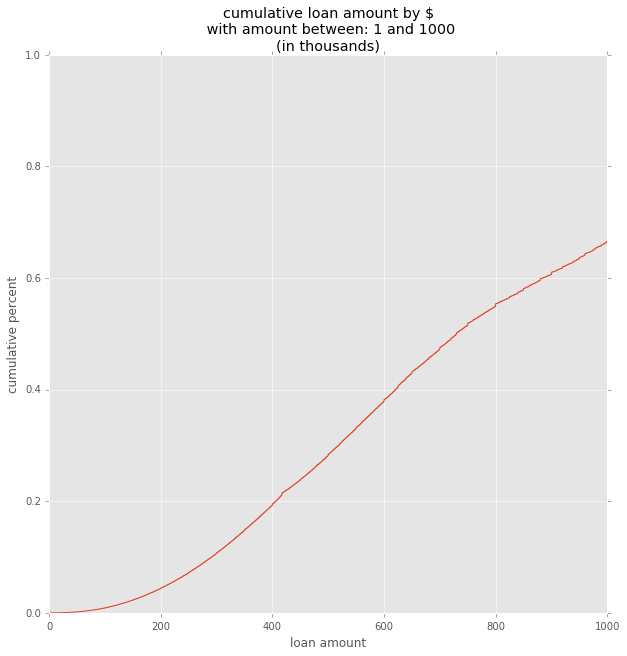

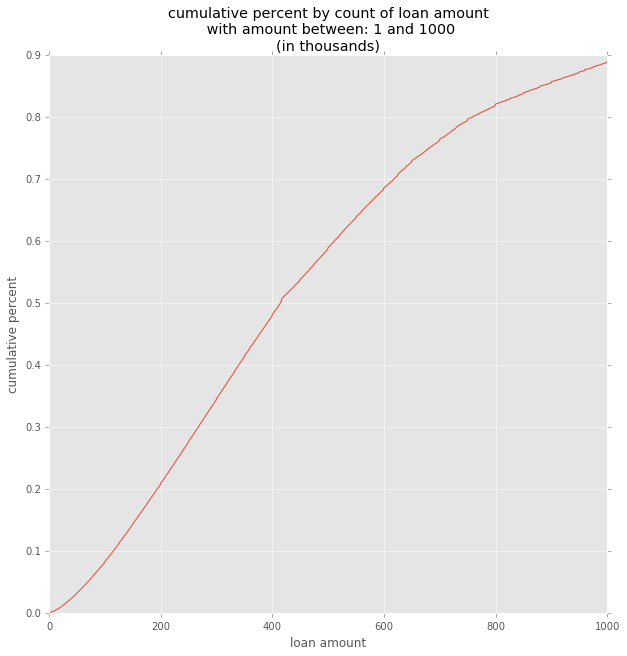

In [8]:
#FIXME add cutoff field name and cutoff value to title
#graph cumulative sum of % of income and % of loan amount 
amt_min = bank_df.amount.min()
amt_max = 1000#bank_df.amount.max()

y = bank_df.cumul_amt_pct[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
x = bank_df.amount[(bank_df.amount < amt_max) & (bank_df.amount > amt_min)]
cumul_pct = plt.figure(figsize=(10,10))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative loan amount by $\n with amount between: {amt_min} and {amt_max}\n(in thousands)'.format(amt_min=amt_min, amt_max=amt_max))
plt.ylabel('cumulative percent')
plt.xlabel('loan amount')
plt.show(cumul_pct)

#y1 = bank_df.cumul_cnt_pct_amt[bank_df[cut_field] < amt_cutoff]
x1 = cnt_amt_df.amount[(cnt_amt_df.amount < amt_max) & (cnt_amt_df.amount > amt_min)]
y1 = cnt_amt_df.cumul_pct_cnt[(cnt_amt_df.amount < amt_max) & ( cnt_amt_df.amount > amt_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
plt.xlabel('loan amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of loan amount\n with amount between: {amt_min} and {amt_max}\n(in thousands)'.format(amt_min=amt_min, amt_max=amt_max))
plt.show(cumul_cnt)


#FIXME modify these graphs by reducing the range of the x axis to see the cumulative curve better
#measureing the $ value of loans shows a high degree of skew due to very large loan amounts
#cutting the tail off the data may be more informative
#the majority of loans by count are under 450-500k, but the raw $ value majority is closer to 2million

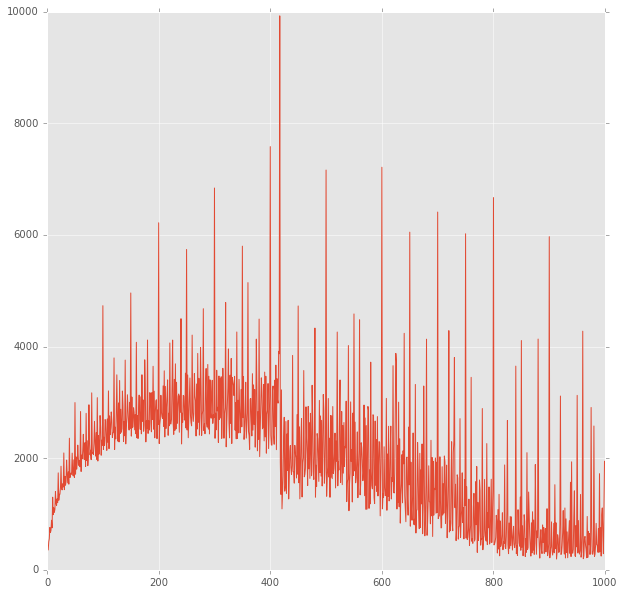

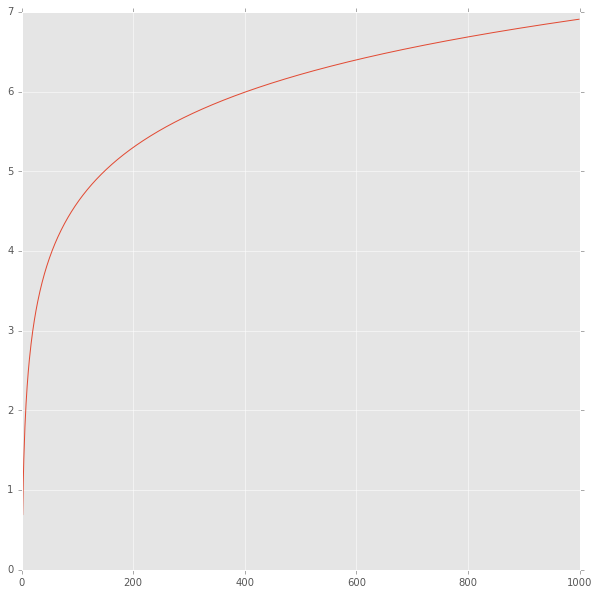

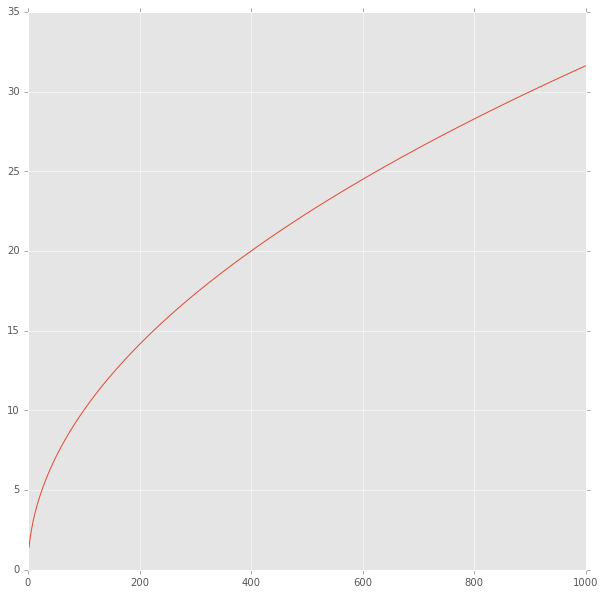

In [9]:
from math import log, sqrt
amt_dist = pd.DataFrame(bank_df.groupby('amount').mult.count())
amt_dist.rename(columns={'mult':'count_amt'},inplace=True)
amt_dist['amount'] = amt_dist.index
amt_dist['amt_log'] = amt_dist.amount.apply(log)
amt_dist['amt_sqrt'] = amt_dist.amount.apply(sqrt)
amt_dist.head()
amt_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y1 = amt_dist.count_amt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
amt_x1 = amt_dist.amount[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]


plt.plot(amt_x1,amt_y1)
plt.show(amt_fig)

#plot logs of amount
log_fig = plt.figure(figsize=(10,10))
ax = plt.subplot()
amt_y2 = amt_dist.amt_log[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y2)
plt.show(log_fig)

#plot sqrt of amount
sqrt_fig = plt.figure(figsize=(10,10))
amt_y3 = amt_dist.amt_sqrt[(amt_dist.amount < amt_max) & ( amt_dist.amount > amt_min)]
plt.plot(amt_x1,amt_y3)
plt.show(sqrt_fig)



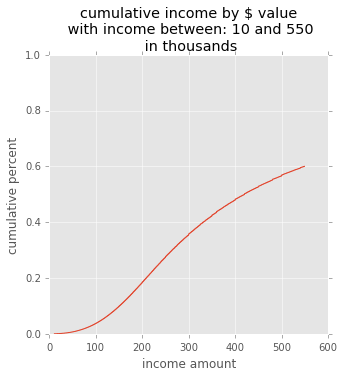

In [10]:
#showing cumulative percent of count of loans by income
#inc_cutoff allows trims max end of distribution
inc_min = 10
inc_max = 550
y = inc_df.cumul_inc_pct[(inc_df.income < inc_max) & (inc_df.income > inc_min)]
x = inc_df.income[(inc_df.income < inc_max) &(inc_df.income > inc_min)]

cumul_inc = plt.figure(figsize=(5,5))
plt.plot(x,y)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.title('cumulative income by $ value\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.ylabel('cumulative percent')
plt.xlabel('income amount')
plt.show(cumul_inc)


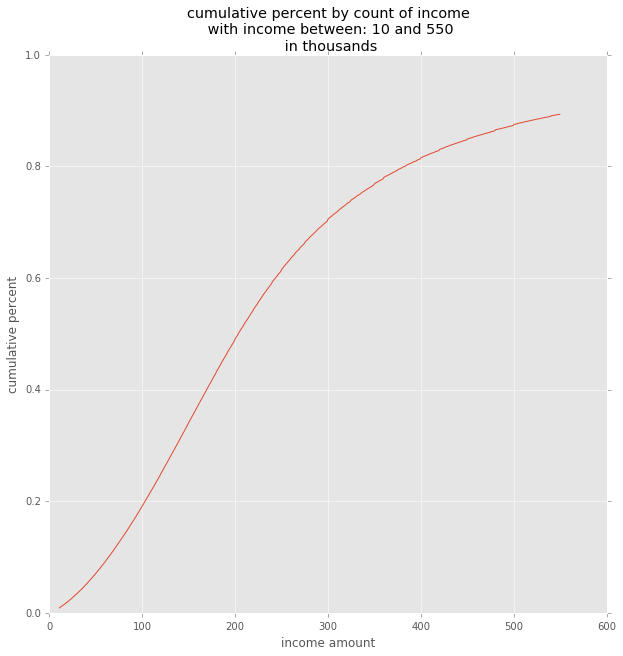

In [11]:
x1 = cnt_inc_df.income[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
y1 = cnt_inc_df.cumul_pct_cnt[(cnt_inc_df.income < inc_max) & (cnt_inc_df.income > inc_min)]
cumul_cnt = plt.figure(figsize=(10,10))
plt.plot(x1,y1)
ax = plt.subplot()
ax.set_ylim([0,1])
plt.xlabel('income amount')
plt.ylabel('cumulative percent')
plt.title('cumulative percent by count of income\n with income between: {inc_min} and {inc_max}\n in thousands'.format(inc_min=inc_min, inc_max=inc_max))
plt.show(cumul_cnt)

588.274665059 std
543.418841138 mean
415.0 median
6000.0 max mult
0.000357142857143 min mult
2000.0 q98
682.0 q75
231.0 q25
36.0 q02
451.0 iqr
-445.5 min_q 1358.5 max_q


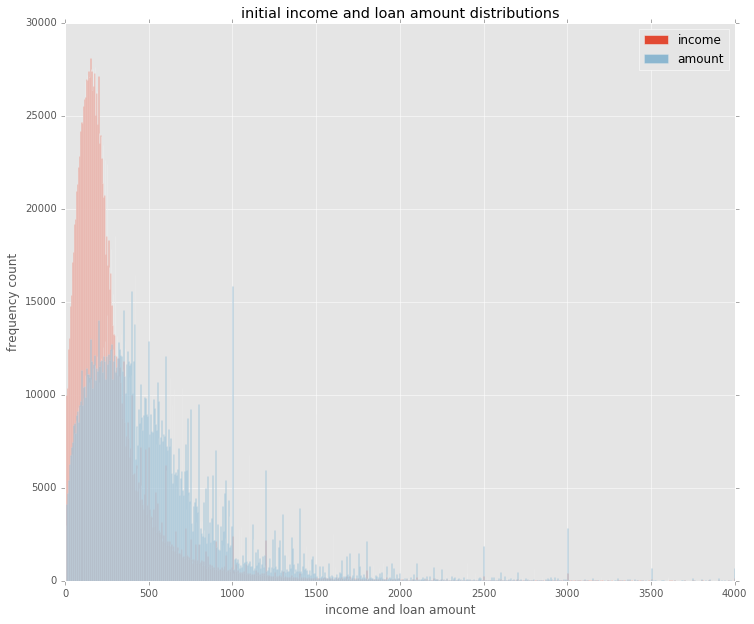

In [13]:
#calculate descriptive stats
print(bank_df.amount.std(), 'std') 
print(bank_df.amount.mean(), 'mean') 
print(bank_df.amount.median(), 'median')
print(bank_df.mult.max(), 'max mult')
print(bank_df.mult.min(), 'min mult')
print(bank_df.amount.quantile(q=.98), 'q98')
print(bank_df.amount.quantile(q=.75), 'q75')
print(bank_df.amount.quantile(q=.25), 'q25')
print(bank_df.amount.quantile(q=.02), 'q02')
q1 = bank_df.amount.quantile(q=.25)
q3 = bank_df.amount.quantile(q=.75)
q98 = bank_df.amount.quantile(q=.98) #potential upper bound for quality
q2 = bank_df.amount.quantile(q=.02) #potential lower bound for quality
iqr =(q3 - q1)
print(iqr, 'iqr')
min_q = q1 - 1.5*iqr #potential lower bound for quality
max_q = q3 + 1.5*iqr #potential upper bound for quality
print(min_q, 'min_q', max_q, 'max_q')


amt = bank_df.amount #get data as series for graphing
inc = bank_df.income #get data as series for graphing
bins = np.linspace(0,4000, 1000) #set ranges and number of bins
bank_viz = plt.figure(figsize=(12,10)) #set plot size
plt.hist(inc, bins, label='income', alpha=1) #plot histogram of income
plt.hist(amt, bins, label='amount', alpha=.5) #plot histogram of loan amount
plt.legend(loc='upper right') #turn on legend and set location
plt.title('initial income and loan amount distributions')
plt.xlabel('income and loan amount')
plt.ylabel('frequency count')
plt.show()
#FIXME add 2 box plot viz

name 0 to 20
std 200.056362271
mean 165.230909003
median 120.0
max_mult 6000.0
med_mult 11.2
min_mult 0.0526315789474
q98 634.5
q02 7.0
q75 209.0
q25 60.0
iqr 149.0
min_q -163.5
max_q 432.5
count of loans 41276
pct of total loans 1.8621698366


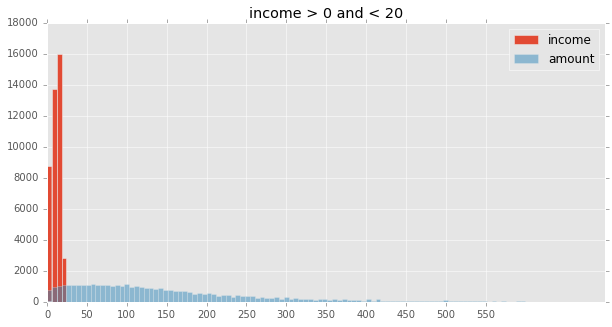

name 20 to 50
std 573.868456927
mean 200.510792606
median 169.0
max_mult 2375.0
med_mult 4.9
min_mult 0.0204081632653
q98 600.0
q02 8.0
q75 265.0
q25 86.0
iqr 179.0
min_q -182.5
max_q 533.5
count of loans 110307
pct of total loans 4.97650858044


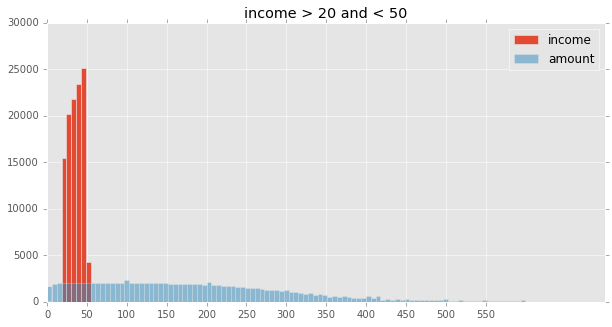

name 50 to 80
std 390.252765929
mean 250.056326131
median 232.0
max_mult 1718.51851852
med_mult 3.5892857142857144
min_mult 0.0126582278481
q98 632.0
q02 14.0
q75 346.0
q25 119.0
iqr 227.0
min_q -221.5
max_q 686.5
count of loans 149167
pct of total loans 6.72968039579


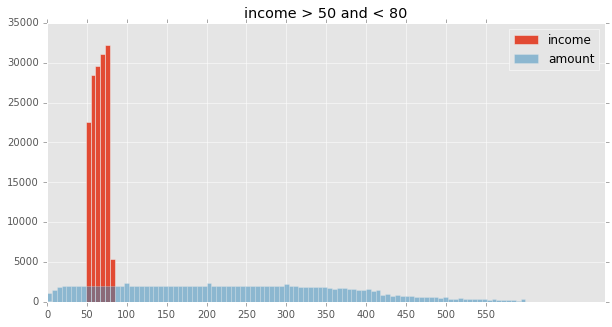

name 80 to 110
std 418.574470944
mean 303.577854266
median 286.0
max_mult 1060.0
med_mult 3.03125
min_mult 0.00917431192661
q98 698.0
q02 23.0
q75 425.0
q25 151.0
iqr 274.0
min_q -260.0
max_q 836.0
count of loans 179258
pct of total loans 8.08723811827


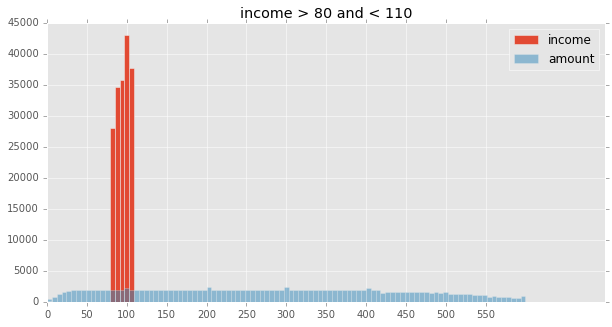

name 110 to 140
std 294.671375331
mean 352.610252756
median 335.0
max_mult 646.363636364
med_mult 2.688
min_mult 0.00719424460432
q98 785.36
q02 35.0
q75 497.0
q25 184.0
iqr 313.0
min_q -285.5
max_q 966.5
count of loans 199283
pct of total loans 8.99066749558


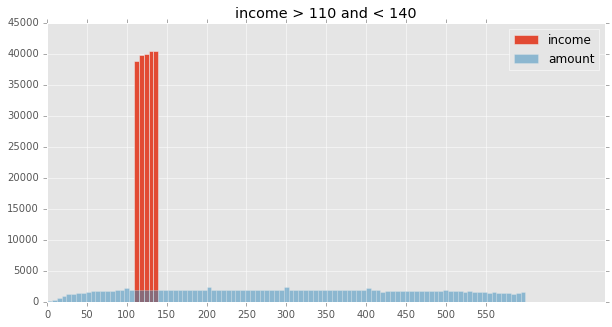

name 140 to 170
std 234.08110693
mean 397.144193522
median 373.0
max_mult 59.6026490066
med_mult 2.4178082191780823
min_mult 0.00591715976331
q98 900.0
q02 50.0
q75 551.0
q25 216.0
iqr 335.0
min_q -286.5
max_q 1053.5
count of loans 204711
pct of total loans 9.2355521228


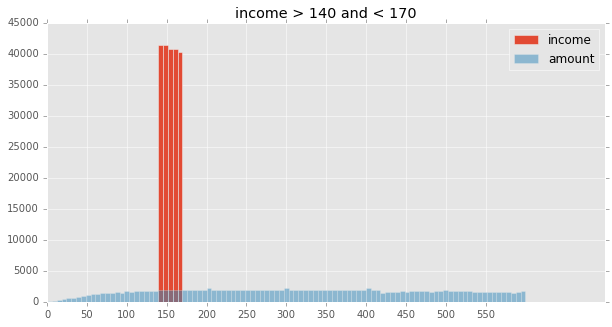

name 170 to 200
std 254.367179526
mean 440.84228781
median 409.0
max_mult 65.9340659341
med_mult 2.225130890052356
min_mult 0.00502512562814
q98 990.0
q02 63.0
q75 600.0
q25 249.0
iqr 351.0
min_q -277.5
max_q 1126.5
count of loans 195768
pct of total loans 8.83208800688


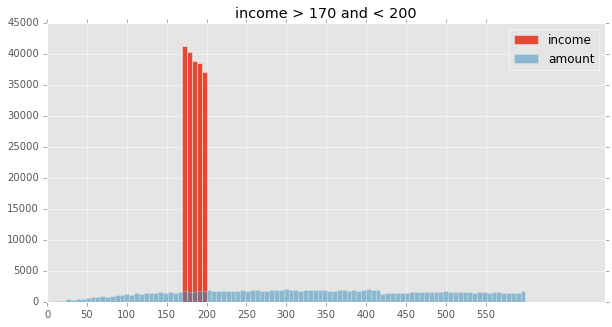

name 200 to 230
std 319.139240689
mean 486.141902037
median 452.0
max_mult 315.492957746
med_mult 2.1144278606965172
min_mult 0.00442477876106
q98 1119.0
q02 76.0
q75 651.0
q25 279.0
iqr 372.0
min_q -279.0
max_q 1209.0
count of loans 176495
pct of total loans 7.96258516598


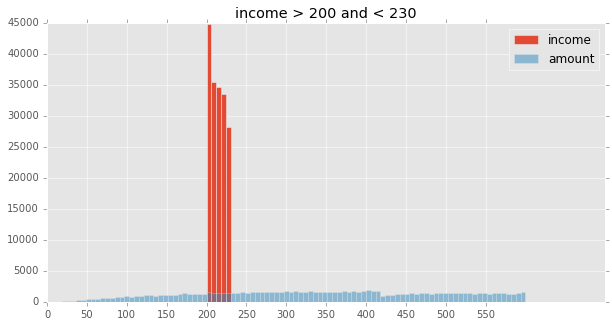

name 230 to 260
std 313.613460119
mean 531.516719513
median 496.0
max_mult 84.0336134454
med_mult 2.036734693877551
min_mult 0.00395256916996
q98 1260.0
q02 86.0
q75 704.0
q25 306.0
iqr 398.0
min_q -291.0
max_q 1301.0
count of loans 147283
pct of total loans 6.64468359444


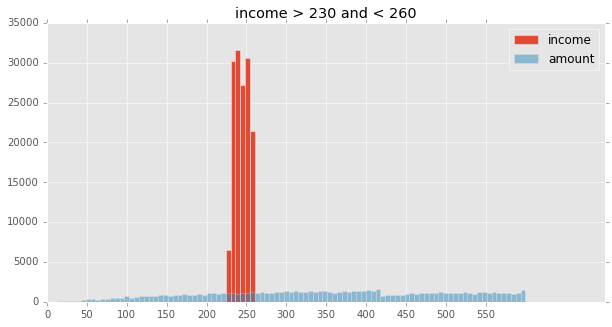

name 260 to 290
std 457.505796839
mean 573.841359608
median 534.0
max_mult 293.165467626
med_mult 1.9494584837545126
min_mult 0.00353356890459
q98 1360.0
q02 97.0
q75 751.0
q25 329.0
iqr 422.0
min_q -304.0
max_q 1384.0
count of loans 119711
pct of total loans 5.40077074594


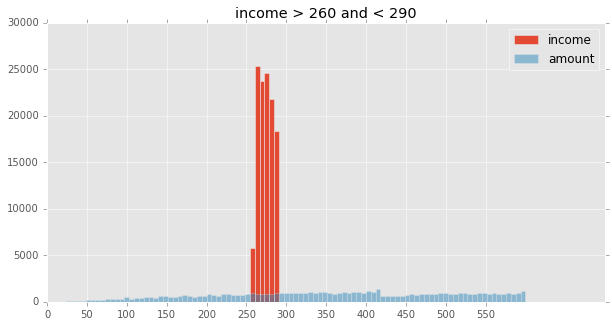

name 290 to 320
std 360.438667239
mean 618.828241385
median 573.0
max_mult 43.3333333333
med_mult 1.8881789137380192
min_mult 0.00324675324675
q98 1480.0
q02 100.0
q75 820.0
q25 350.0
iqr 470.0
min_q -355.0
max_q 1525.0
count of loans 97736
pct of total loans 4.40936697234


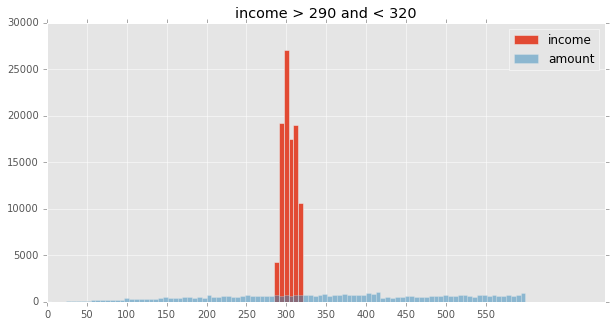

name 320 to 350
std 382.531473289
mean 659.12034015
median 608.0
max_mult 18.0303030303
med_mult 1.8189919610746772
min_mult 0.00290697674419
q98 1580.0
q02 105.0
q75 878.0
q25 368.0
iqr 510.0
min_q -397.0
max_q 1643.0
count of loans 78436
pct of total loans 3.53864602441


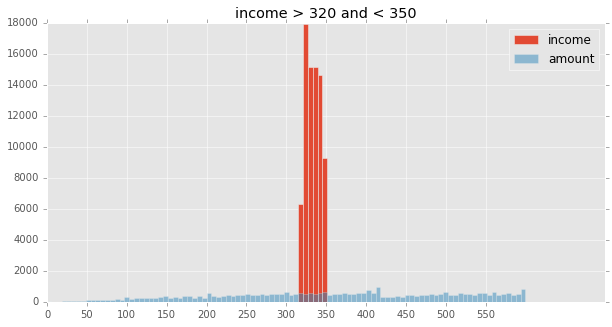

name 350 to 380
std 414.447807616
mean 693.003977608
median 630.0
max_mult 24.7282608696
med_mult 1.7348896537149412
min_mult 0.00268817204301
q98 1731.26
q02 104.0
q75 926.0
q25 376.0
iqr 550.0
min_q -449.0
max_q 1751.0
count of loans 67880
pct of total loans 3.06241129248


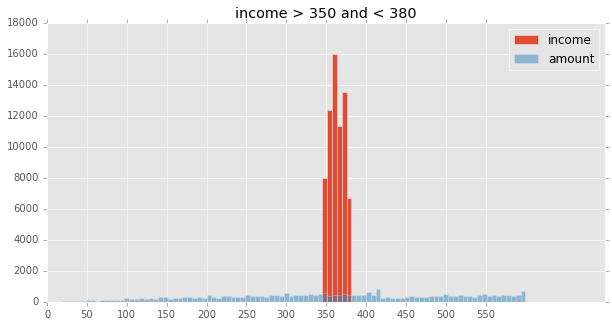

name 380 to 410
std 445.923379438
mean 727.496531454
median 650.0
max_mult 38.1679389313
med_mult 1.6581304758407218
min_mult 0.0025
q98 1830.0
q02 108.0
q75 970.0
q25 390.0
iqr 580.0
min_q -480.0
max_q 1840.0
count of loans 54778
pct of total loans 2.47131357955


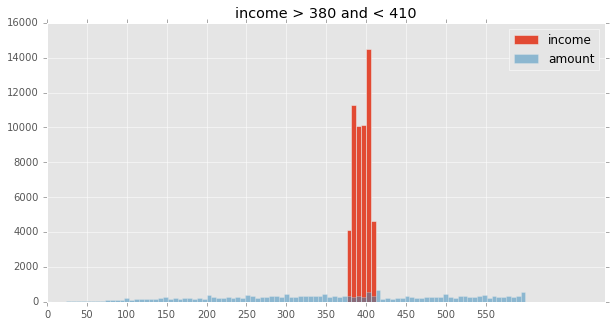

name 410 to 440
std 476.334691441
mean 772.618000988
median 696.0
max_mult 23.7677725118
med_mult 1.6401894429786466
min_mult 0.00231481481481
q98 1946.18
q02 107.0
q75 1035.0
q25 406.0
iqr 629.0
min_q -537.5
max_q 1978.5
count of loans 44542
pct of total loans 2.00951567162


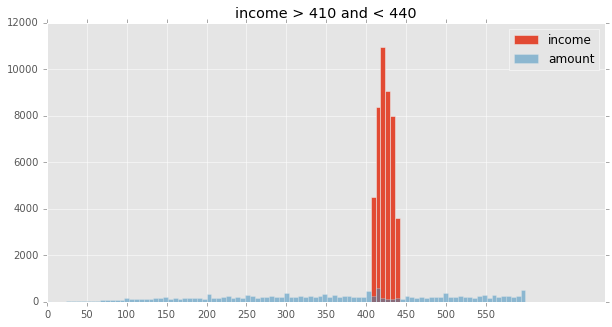

name 440 to 470
std 714.983612936
mean 802.931980619
median 713.0
max_mult 219.296052632
med_mult 1.5739514348785872
min_mult 0.00226757369615
q98 2000.0
q02 108.0
q75 1084.0
q25 412.0
iqr 672.0
min_q -596.0
max_q 2092.0
count of loans 37357
pct of total loans 1.68536385759


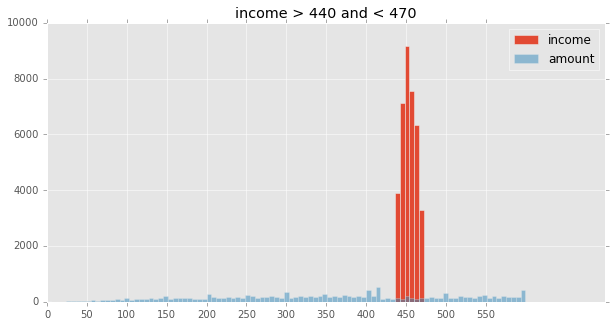

name 470 to 500
std 530.583820664
mean 830.370275808
median 730.0
max_mult 14.1975308642
med_mult 1.506276150627615
min_mult 0.0020325203252
q98 2100.0
q02 107.0
q75 1125.0
q25 417.0
iqr 708.0
min_q -645.0
max_q 2187.0
count of loans 31725
pct of total loans 1.43127575507


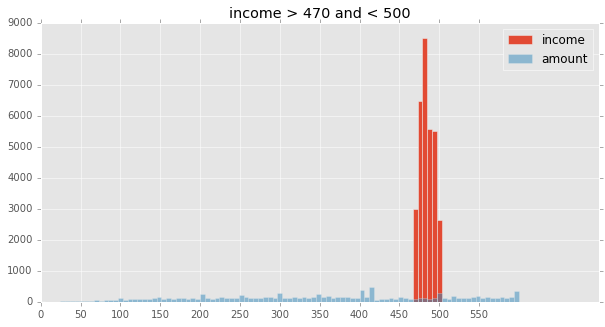

name 500 to 530
std 577.505524789
mean 868.762447883
median 750.0
max_mult 33.0097087379
med_mult 1.4705882352941178
min_mult 0.00196078431373
q98 2295.0
q02 112.4
q75 1197.0
q25 425.0
iqr 772.0
min_q -733.0
max_q 2355.0
count of loans 29021
pct of total loans 1.30928459221


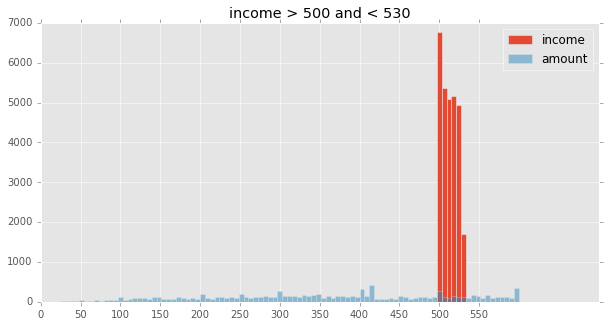

name 530 to 560
std 592.845001908
mean 897.636367531
median 775.0
max_mult 16.5441176471
med_mult 1.4233576642335766
min_mult 0.0179211469534
q98 2405.0
q02 109.88
q75 1240.0
q25 428.0
iqr 812.0
min_q -790.0
max_q 2458.0
count of loans 23345
pct of total loans 1.05321142639


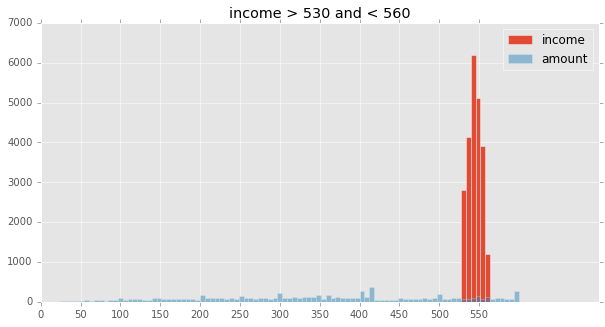

name 560 to 590
std 607.2786923
mean 922.229205176
median 800.0
max_mult 26.5486725664
med_mult 1.4035087719298245
min_mult 0.00520833333333
q98 2400.0
q02 112.0
q75 1276.0
q25 451.5
iqr 824.5
min_q -785.25
max_q 2512.75
count of loans 18935
pct of total loans 0.854253945539


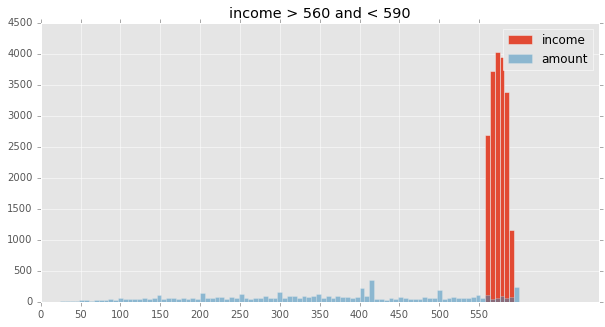

name 590 to 620
std 643.267411326
mean 950.263921237
median 818.5
max_mult 22.8155339806
med_mult 1.355
min_mult 0.00332225913621
q98 2550.0
q02 110.0
q75 1313.0
q25 450.0
iqr 863.0
min_q -844.5
max_q 2607.5
count of loans 18892
pct of total loans 0.852313997313


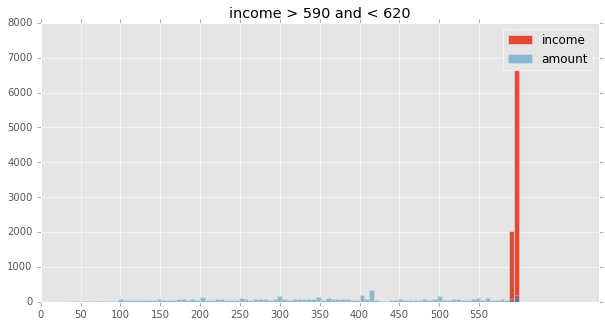

name 620 to 650
std 657.42928535
mean 974.647248285
median 846.0
max_mult 10.9204368175
med_mult 1.3343925252515056
min_mult 0.00156494522692
q98 2647.52
q02 110.0
q75 1350.75
q25 452.5
iqr 898.25
min_q -894.875
max_q 2698.125
count of loans 14282
pct of total loans 0.644333501462


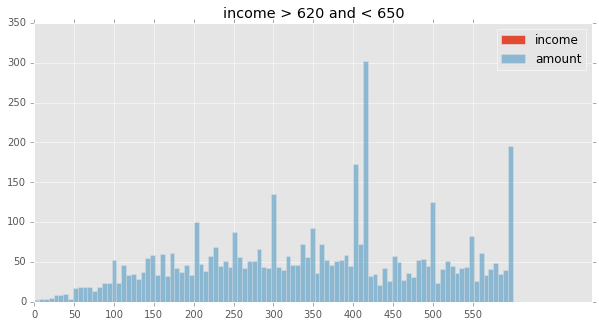

name 650 to 680
std 701.792926438
mean 1013.22273581
median 878.5
max_mult 14.8148148148
med_mult 1.3228451178451177
min_mult 0.00150602409639
q98 2750.0
q02 114.0
q75 1400.0
q25 475.0
iqr 925.0
min_q -912.5
max_q 2787.5
count of loans 13846
pct of total loans 0.624663328753


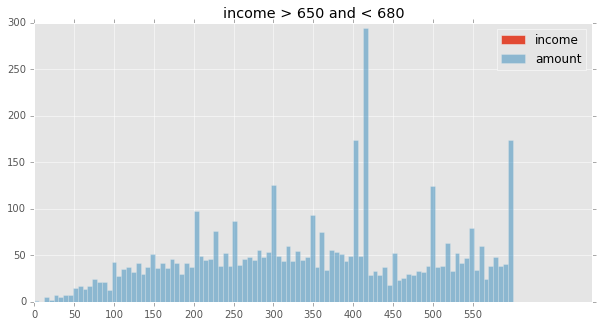

name 680 to 710
std 699.736756884
mean 1024.79681174
median 896.0
max_mult 9.28571428571
med_mult 1.2826423547627284
min_mult 0.0113798008535
q98 2817.8
q02 120.0
q75 1406.0
q25 482.0
iqr 924.0
min_q -904.0
max_q 2792.0
count of loans 11856
pct of total loans 0.534884329459


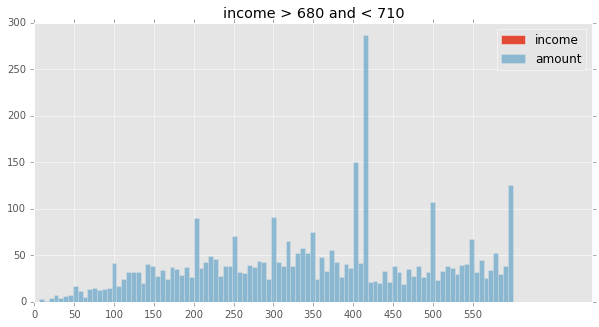

name 710 to 740
std 757.663505599
mean 1065.73926721
median 910.0
max_mult 14.8965517241
med_mult 1.2602739726027397
min_mult 0.00409836065574
q98 3000.0
q02 104.0
q75 1480.0
q25 496.75
iqr 983.25
min_q -978.125
max_q 2954.875
count of loans 10808
pct of total loans 0.487603730836


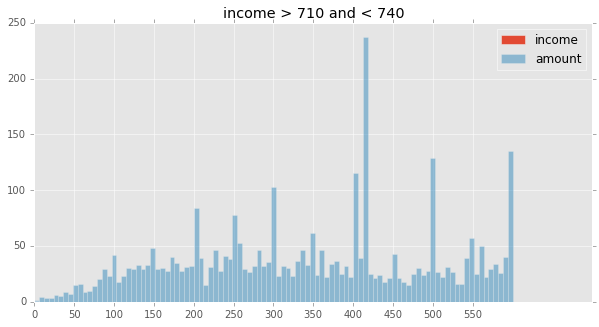

In [15]:
#Cycle over different income bins and plot loan amount distribution for each
#focus on finding the best bins
#repeat for different SQL selection filters (junior liens, non-owner-occupied, VA/FHA/RHS loans, manufactured housing)
bin_min = 0
bin_max = 20
bin_step = 30
pct_of_loans = OrderedDict({})
first = True
while bin_max < 751:
    graph_bin = bank_df[(bank_df.income >=bin_min) & (bank_df.income < bin_max)] #create bin of of amount for selected income
    #set descriptive stats
    bin_stats = OrderedDict({})
    bin_stats['name'] = str(bin_min) + ' to ' + str(bin_max)
    bin_stats['std']= graph_bin.amount.std()
    bin_stats['mean'] = graph_bin.amount.mean()
    bin_stats['median'] = graph_bin.amount.median()
    bin_stats['max_mult'] = graph_bin.mult.max()
    bin_stats['med_mult'] = graph_bin.mult.median()
    bin_stats['min_mult'] = graph_bin.mult.min()
    bin_stats['q98'] = graph_bin.amount.quantile(q=.98)
    bin_stats['q02'] = graph_bin.amount.quantile(q=.02)
    bin_stats['q75'] = graph_bin.amount.quantile(q=.75)
    bin_stats['q25'] = graph_bin.amount.quantile(q=.25)
    bin_stats['iqr'] = bin_stats['q75'] - bin_stats['q25']
    bin_stats['min_q'] = bin_stats['q25'] - 1.5 * bin_stats['iqr']
    bin_stats['max_q'] = bin_stats['q75'] + 1.5 * bin_stats['iqr']
    bin_stats['count of loans'] = graph_bin.amount.count()
    bin_stats['pct of total loans'] = (graph_bin.amount.count() / bank_df.income.count()) * 100
    
    if first:
        first=False
        bin_df = pd.DataFrame(bin_stats, index=range(1))
    else:

        concat_df = pd.DataFrame(bin_stats, index=range(1))
        bin_df = pd.concat([bin_df, concat_df], axis=0)
    for key, value in bin_stats.items():
        print(key,value)
    
    amt = graph_bin.amount#.apply(sqrt)
    inc = graph_bin.income#.apply(sqrt) #square roots show much nicer distributions of amount to income
    xmin = 0 #set minimum x axis value
    xmax = 600 #set maximum x axis value
    xsteps= 100 #set steps on x axis (bins)
    bins = np.linspace(xmin,xmax, xsteps)
    #print(bins)
    bin_viz = plt.figure(figsize=(10,5))
    plt.hist(inc, bins, label='income', alpha=1)
    plt.hist(amt, bins, label='amount', alpha=.5)
    plt.title('income > '+str(bin_min)+' and < '+str(bin_max))
    plt.legend(loc='upper right')
    plt.xticks(np.arange(xmin,xmax, 50))
    ax = plt.subplot()
    #ax.set_ylim(0, 2000)
    plt.show(bin_viz)
    bin_min=bin_max
    bin_max += bin_step
    pct_of_loans[bin_max] = bin_stats['pct of total loans']
bin_df.reset_index(inplace=True, drop=True)
path = 'linked_dist_stats/'
if not os.path.exists(path):
    os.makedirs(path)
bin_df.to_csv(path+'no_mod.csv')

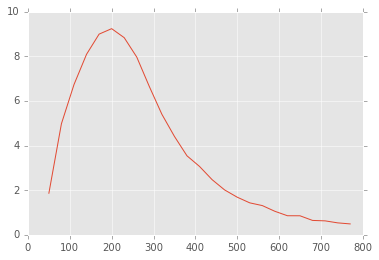

In [16]:
#graph percent of loans by top of income bin
y = []
x = []
for key, value in pct_of_loans.items():
    y.append(value)
    x.append(key)
plt.plot(x,y)


In [17]:
#make data adjustments and calculate desc stat deltas and regraph
#use this work to refine income bins and associated loan amount distributions
bin_df.head(100)


,name,std,mean,median,max_mult,med_mult,min_mult,q98,q02,q75,q25,iqr,min_q,max_q,count of loans,pct of total loans
0,0 to 20,200.056362,165.230909,120.0,6000.000000,11.200000,0.052632,634.50,7.00,209.00,60.00,149.00,-163.500,432.500,41276,1.862170
1,20 to 50,573.868457,200.510793,169.0,2375.000000,4.900000,0.020408,600.00,8.00,265.00,86.00,179.00,-182.500,533.500,110307,4.976509
2,50 to 80,390.252766,250.056326,232.0,1718.518519,3.589286,0.012658,632.00,14.00,346.00,119.00,227.00,-221.500,686.500,149167,6.729680
3,80 to 110,418.574471,303.577854,286.0,1060.000000,3.031250,0.009174,698.00,23.00,425.00,151.00,274.00,-260.000,836.000,179258,8.087238
4,110 to 140,294.671375,352.610253,335.0,646.363636,2.688000,0.007194,785.36,35.00,497.00,184.00,313.00,-285.500,966.500,199283,8.990667
5,140 to 170,234.081107,397.144194,373.0,59.602649,2.417808,0.005917,900.00,50.00,551.00,216.00,335.00,-286.500,1053.500,204711,9.235552
6,170 to 200,254.367180,440.842288,409.0,65.934066,2.225131,0.005025,990.00,63.00,600.00,249.00,351.00,-277.500,1126.500,195768,8.832088
7,200 to 230,319.139241,486.141902,452.0,315.492958,2.114428,0.004425,1119.00,76.00,651.00,279.00,372.00,-279.000,1209.000,176495,7.962585
8,230 to 260,313.613460,531.516720,496.0,84.033613,2.036735,0.003953,1260.00,86.00,704.00,306.00,398.00,-291.000,1301.000,147283,6.644684
9,260 to 290,457.505797,573.841360,534.0,293.165468,1.949458,0.003534,1360.00,97.00,751.00,329.00,422.00,-304.000,1384.000,119711,5.400771


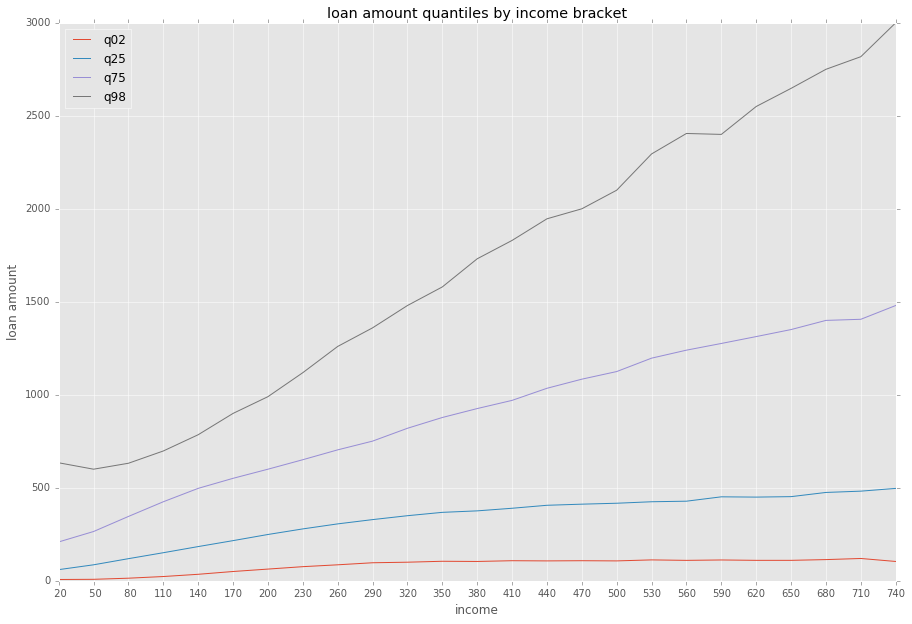

In [19]:
fig = plt.figure(figsize=(15,10))
xticks=[x[-3:] for x in bin_df.name] #get xtick names as list
ax = plt.subplot()
plt.xticks(x,xticks) #set xtick names
x = range(len(bin_df.name))

y = bin_df.q02
y1 = bin_df.q25
y2 = bin_df.q75
y3 = bin_df.q98
plt.plot(x,y, label='q02')
plt.plot(x,y1, label='q25')
plt.plot(x,y2, label='q75')
plt.plot(x,y3, label='q98')
plt.ylabel('loan amount')
plt.xlabel('income')
plt.legend(loc='upper left') #turn on legend and set location
plt.title('loan amount quantiles by income bracket')
plt.show(fig)
